In [29]:
from tensorflow import keras
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import numpy as np
import os
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, classification_report, confusion_matrix, accuracy_score,precision_recall_curve, average_precision_score
import json

In [2]:
X_train = pd.read_csv('./data/x_train_over.csv')
Y_train = pd.read_csv('./data/y_train_over.csv')
X_test = pd.read_csv('./data/x_test.csv')
Y_test = pd.read_csv('./data/y_test.csv')

In [3]:
X_train, X_cv, Y_train, Y_cv=train_test_split(X_train, Y_train, test_size=0.2, random_state=44, stratify=Y_train)

In [4]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((125427, 83), (125427, 1), (36557, 83), (36557, 1))

In [5]:
Y_train.value_counts()

Default
1          62714
0          62713
dtype: int64

In [6]:
#체크포인트 생성및 조기종료 조건 
checkpoint_path_elu = "saved_models/rd_date0407-{epoch:03d}-{val_loss:.3f}.h5"
checkpoint_dir_elu = os.path.dirname(checkpoint_path_elu)

elu_cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_elu, save_weights_only=False, verbose=1,)


earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=15)

In [35]:
elu_neural_model = tf.keras.models.Sequential(
    [
        keras.layers.Dense(units=140, input_shape=(83,), activation='elu',kernel_regularizer=tf.keras.regularizers.L2(0)),
        keras.layers.Dense(units=140,  activation='elu', kernel_regularizer=tf.keras.regularizers.L2(0)),
        keras.layers.Dense(units=40, activation='elu', kernel_regularizer=tf.keras.regularizers.L2(0.00)),
        keras.layers.Dropout(0.3),   
        keras.layers.Dense(units=1, activation='sigmoid'),
        

    ]
    ,name='predict'
)

In [36]:
elu_neural_model.summary()

Model: "predict"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 140)               11760     
                                                                 
 dense_5 (Dense)             (None, 140)               19740     
                                                                 
 dense_6 (Dense)             (None, 40)                5640      
                                                                 
 dropout_1 (Dropout)         (None, 40)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 41        
                                                                 
Total params: 37,181
Trainable params: 37,181
Non-trainable params: 0
_________________________________________________________________


In [9]:
elu_neural_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=tf.keras.losses.BinaryCrossentropy(from_logits=False,label_smoothing=0),
metrics=['binary_accuracy','Recall','Precision' ] )

In [10]:
# history = elu_neural_model.fit(X_train, Y_train.to_numpy(), epochs=200, callbacks=[elu_cp_callback,earlystop_callback], validation_data=(X_cv,Y_cv) ,batch_size=50)

In [11]:
# history_dict = history.history


In [12]:
# json.dump(history.history, open('after_history_dicts.json', 'w'))

In [10]:
history_dict = json.load(open('after_history_dicts.json', 'r'))

(0.0, 1.5)

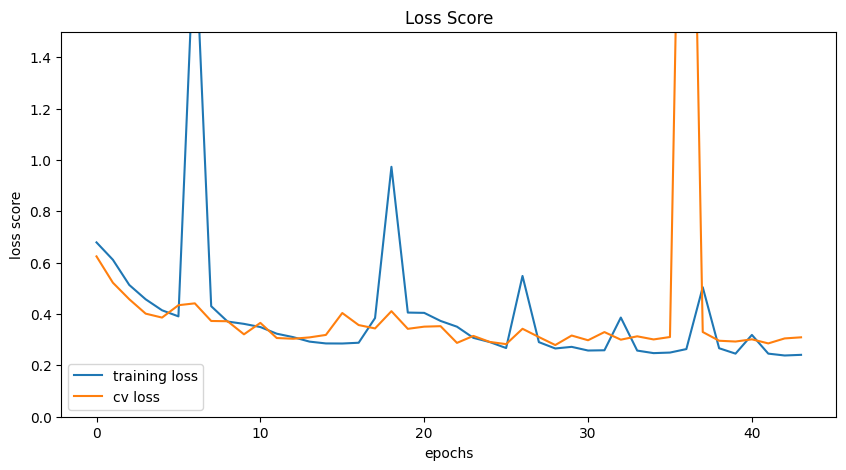

In [11]:
x = list(i for i in range(len(history_dict.get('loss'))))
graph_train_recall = history_dict.get('loss')
graph_test_recall = history_dict.get('val_loss')
plt.figure(figsize=(10, 5))
sns.lineplot(x=x,y=graph_train_recall, label='training loss')
sns.lineplot(x=x,y=graph_test_recall, label='cv loss')
plt.legend()
plt.title('Loss Score')
plt.xlabel('epochs')
plt.ylabel('loss score')
plt.ylim((0,1.5))

Loss Score (0.2792655825614929)로 가장낮은 29 번째 가중치를 사용

In [12]:
np.argmin(history_dict.get('val_loss'))

28

In [13]:
np.argmin(history_dict.get('val_loss'))

28

In [66]:
# 
elu_neural_model.load_weights('./saved_models/rd_date0407-029-0.279.h5')

In [67]:
predic_test_y = elu_neural_model.predict(X_test)
predic_train_y = elu_neural_model.predict(X_train)

3920/3920 [==============================] - 6s 1ms/step


In [68]:
bin_y_test = (predic_test_y > .5).astype(int)
bin_y_train  = (predic_train_y > .5).astype(int)
bin_y_test = bin_y.reshape(-1)
bin_y_train = bin_y_train.reshape(-1)

### 채점 

In [69]:
cm2 = confusion_matrix(Y_test,bin_y_test)
cmdf2 = pd.DataFrame(cm2, index=['Expected(N)', 'Expected(P)'], columns=['Predicted(N)', 'Predicted(P)'])
cmdf2


,Predicted(N),Predicted(P)
Expected(N),30363,3256
Expected(P),2363,575


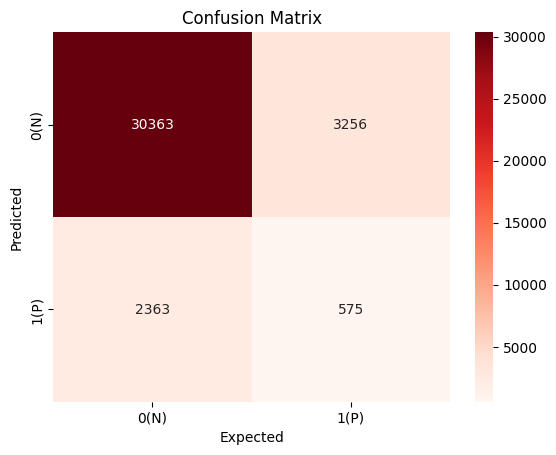

In [70]:
sns.heatmap(cm2, annot = True, fmt = 'd',cmap = 'Reds')
plt.xlabel('Expected')
plt.ylabel('Predicted')
plt.xticks([0.5,1.5],['0(N)', '1(P)'])
plt.yticks([0.5,1.5],['0(N)', '1(P)'])
plt.title('Confusion Matrix')
plt.show()


In [71]:
report =    classification_report(Y_test,bin_y_test)

In [72]:
print(report)
print (f'Accuracy on Training set :{accuracy_score(Y_train, bin_y_train):.3f}' )
print (f'Accuracy on Test set :{ accuracy_score(Y_test, bin_y_test):.3f}' )

              precision    recall  f1-score   support

           0       0.93      0.90      0.92     33619
           1       0.15      0.20      0.17      2938

    accuracy                           0.85     36557
   macro avg       0.54      0.55      0.54     36557
weighted avg       0.87      0.85      0.86     36557

Accuracy on Training set :0.923
Accuracy on Test set :0.846


In [73]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

fpr, tpr, _ = roc_curve(y_true=Y_test, y_score=predic_test_y)  # real y & predicted y (based on "Sepal width")

roc_auc = auc(fpr, tpr)  # AUC 면적의 값 (수치)


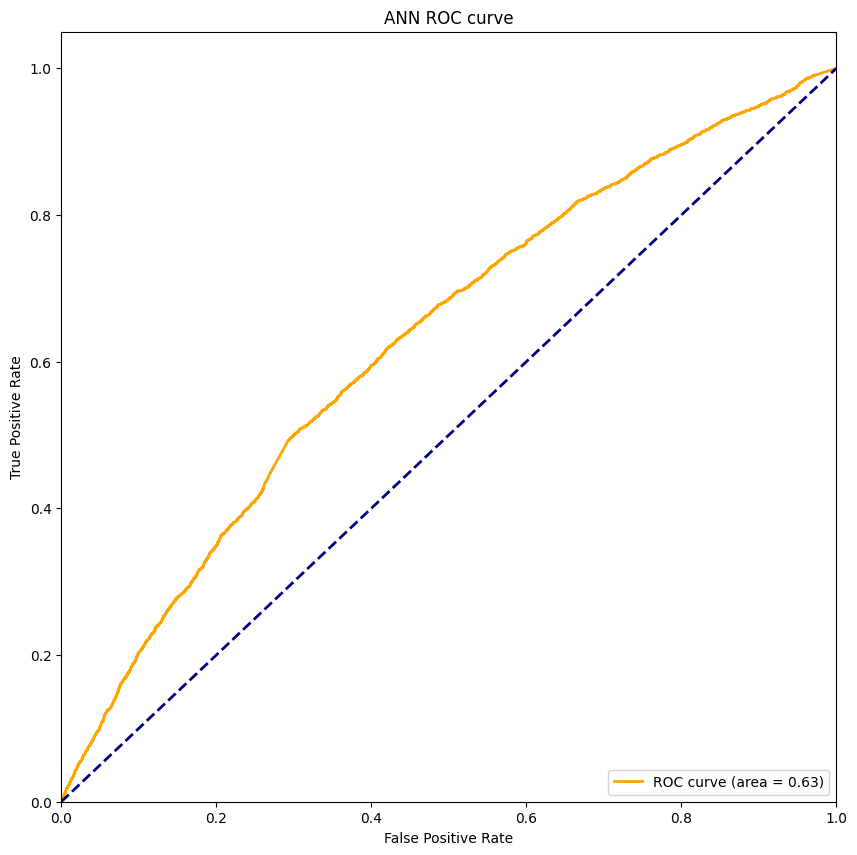

In [74]:
plt.figure(figsize=(10, 10))


plt.plot(fpr, tpr, color='orange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title("ANN ROC curve")

plt.show()


In [75]:
float(Y_test.mean())

0.08036764504746013

(0.03036764504746013, 1.01)

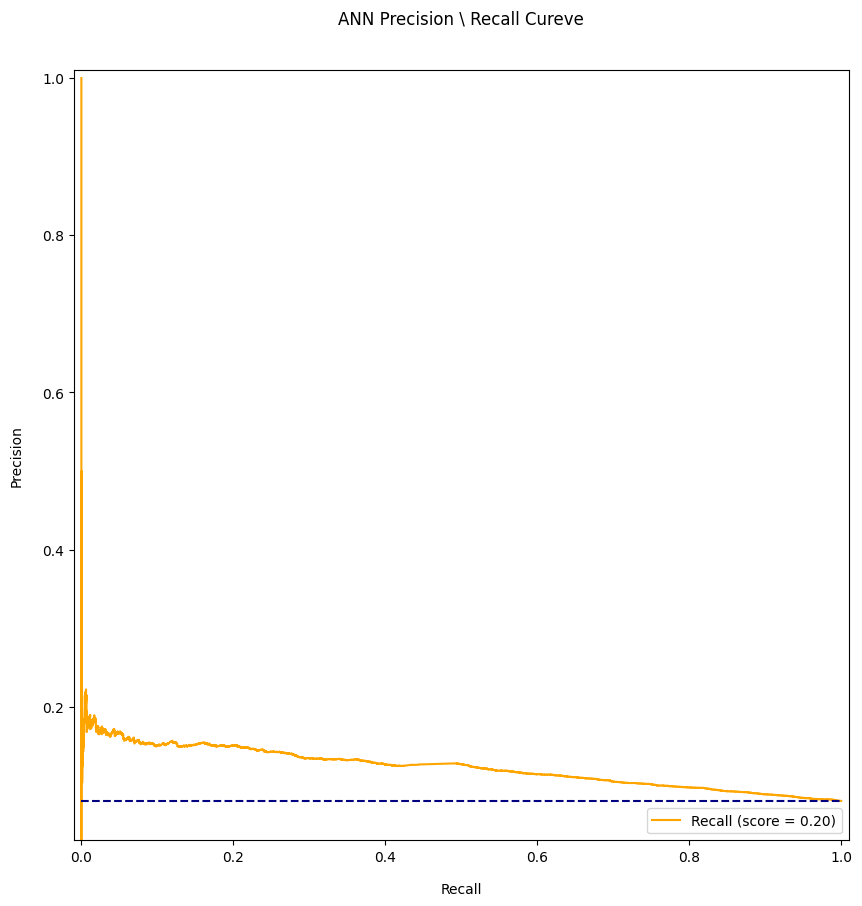

In [76]:
# Precision-Recall Curve 그리기
fpr, tpr, _ = precision_recall_curve(y_true=Y_test, probas_pred=predic_test_y)
plt.figure(figsize=(10, 10))

plt.plot(tpr, fpr, 'orange', label='Recall (score = %0.2f)' %recall_score(Y_test, bin_y_test))
base_rate = float(Y_test.mean())
plt.plot([0,1],[base_rate,base_rate],'--', color='navy')

#styling figure
plt.title('ANN Precision \ Recall Cureve',y=1.05)
plt.xlabel('Recall',labelpad=13)
plt.ylabel('Precision',labelpad=13,)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
plt.legend(loc="lower right")

plt.xlim(-0.01,1.01)
plt.ylim(base_rate-0.05,1.01, )